In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
from collections import defaultdict
import pickle
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

# todo: select model here, uncomment to select the model
from models import Alex_256_relu as m
# from models import Alex_256_sigmoid as m
# from models import Alex_256_tanh as m
# from models import Alex_4096_relu as m
# from models import Alex_4096_tanh as m

from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os
import random

# 0. Data Pre-processing

In [2]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # turn the graph to single color channel
    transforms.Resize((227, 227)), # resize to 227 * 227 because we use AlexNet
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485], std=[0.229])  # normalize
])

train_dataset1 = datasets.ImageFolder('../dataset/train', transform=data_transforms)
torch.manual_seed(42)
train_size = int(0.9 * len(train_dataset1))
val_size = len(train_dataset1) - train_size
train_dataset1, val_dataset1 = random_split(train_dataset1, [train_size, val_size])
test_dataset1 = datasets.ImageFolder('../dataset/test', transform=data_transforms)
train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
val_loader1 = DataLoader(val_dataset1, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)
test_loader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False, num_workers=16, pin_memory=False)

train_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/train', transform=data_transforms)
test_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/test', transform=data_transforms)
val_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/valid', transform=data_transforms)
train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
val_loader2 = DataLoader(val_dataset2, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False, num_workers=16, pin_memory=False)


batch_size = 64
# make sure the mix of dataloader is balanced
def combine_data(dataset1, dataset2, batch_size, shuffle, pin, nw):
    len_dataset1 = len(dataset1)
    len_dataset2 = len(dataset2)
    if len_dataset1 > len_dataset2:
        larger_dataset = dataset1
        smaller_dataset = dataset2
    else:
        larger_dataset = dataset2
        smaller_dataset = dataset1
    num_samples_to_select = len(smaller_dataset)
    selected_samples = random.sample(range(len(larger_dataset)), num_samples_to_select)
    selected_larger_dataset = Subset(larger_dataset, selected_samples)
    combined_dataset = ConcatDataset([smaller_dataset, selected_larger_dataset])
    dataloader = DataLoader(combined_dataset, batch_size=batch_size, 
                            shuffle=shuffle, pin_memory=pin, num_workers=nw)
    return dataloader

def imbalance_combine_data(dataset1, dataset2, batch_size, shuffle, pin, nw):
    combined_dataset = ConcatDataset([dataset1, dataset2])
    dataloader = DataLoader(combined_dataset, batch_size=batch_size, 
                            shuffle=shuffle, pin_memory=pin, num_workers=nw)
    return dataloader

train_loader = combine_data(train_dataset1, train_dataset2, batch_size, True, True, 16)
val_loader = combine_data(val_dataset1, val_dataset2, batch_size, True, False, 16)
test_loader = combine_data(test_dataset1, test_dataset2, batch_size, False, False, 16)

# train_loader = imbalance_combine_data(train_dataset1, train_dataset2, 64, True, True, 16)
# val_loader = imbalance_combine_data(val_dataset1, val_dataset2, 64, True, False, 16)
# test_loader = imbalance_combine_data(test_dataset1, test_dataset2, 64, False, False, 16)

train_loader = train_loader1
val_loader = val_loader1
test_loader = test_loader1

# check if the size of each label is balanced
def check_label_size(dataloader):
    label_counts = defaultdict(int)
    for _, labels in dataloader:
        labels = labels.tolist()
        for label in labels:
            label_counts[label] += 1
    for label, count in label_counts.items():
        print(f"Label {label}: {count} samples")
    print()
    return label_counts
train_label_count = check_label_size(train_loader)
val_label_count = check_label_size(val_loader)
test_label_count = check_label_size(test_loader)

# adjust the weight of each label
class_weights = {}
for class_label, class_count in train_label_count.items():
    class_weights[class_label] = (len(train_loader)*batch_size) / (len(train_label_count) * class_count)
print(f"adjust weight: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()))).to('cuda:0')
# criterion = nn.CrossEntropyLoss()

Label 5: 7763 samples
Label 3: 14361 samples
Label 2: 5022 samples
Label 0: 5426 samples
Label 6: 5126 samples
Label 4: 12635 samples
Label 1: 1343 samples

Label 0: 541 samples
Label 4: 1504 samples
Label 3: 1652 samples
Label 1: 130 samples
Label 6: 559 samples
Label 2: 539 samples
Label 5: 817 samples

Label 0: 1392 samples
Label 1: 401 samples
Label 2: 1314 samples
Label 3: 4027 samples
Label 4: 3628 samples
Label 5: 2178 samples
Label 6: 1416 samples

adjust weight: {5: 0.9516203235126331, 3: 0.5144090642315, 2: 1.4710132559594926, 0: 1.3614870201674478, 6: 1.4411682737862996, 4: 0.5846797444739669, 1: 5.500691415806829}


In [3]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# 1. Model

In [4]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [5]:
# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"

# saving path
m.update_file_name(optimizer_name + "_dataset2")

# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
# optimizer = optimizer.create_optimizer(model.parameters(), optimizer_name)

lr_scheduler = ReduceLROnPlateau(
            optimizer,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=5,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

In [6]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
different = 0.001 # different between the best val loss and the most recent one
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

In [7]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forwarding get output
        outputs = model(inputs)
        # compute loss of output
        loss = criterion(outputs, labels)
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record training status
        running_loss += loss.item()
        prediction = outputs.argmax(dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                prediction = outputs.argmax(dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

loss= 0.11280 - val loss= 2.25832 - accuracy= 92.700% - val accuracy= 59.349% - best= 60.839% - Counter= 0/10:   3%|▌                   | 61/2000 [12:14<6:29:00, 12.04s/epoch]


Trigger Early Stopping



# 2. Save model and records

In [8]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 3. Plot records and Evaluation

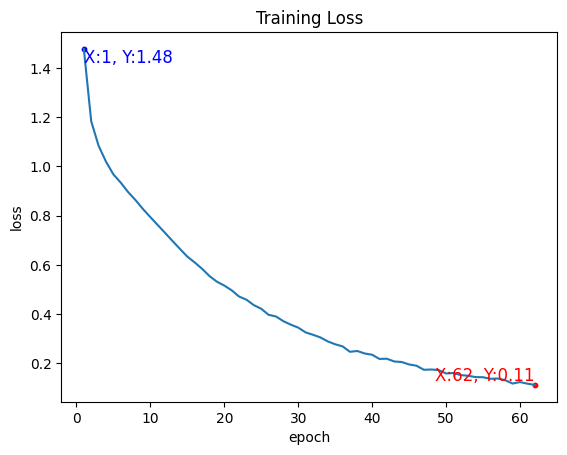

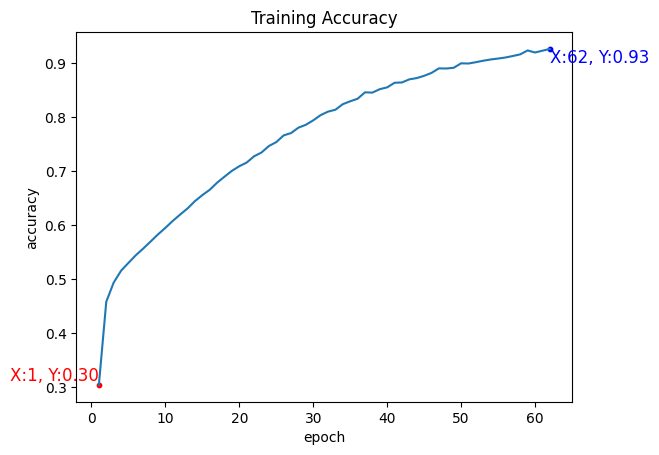

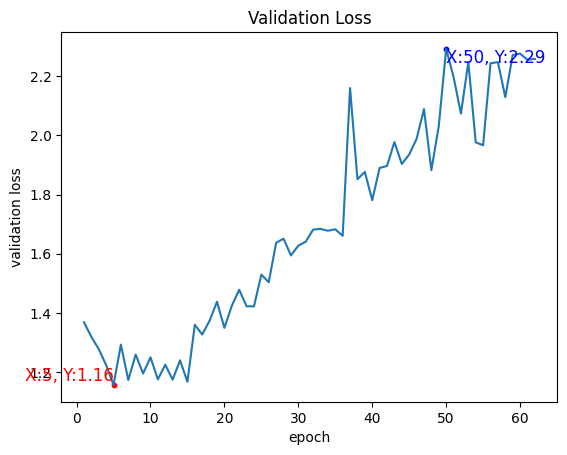

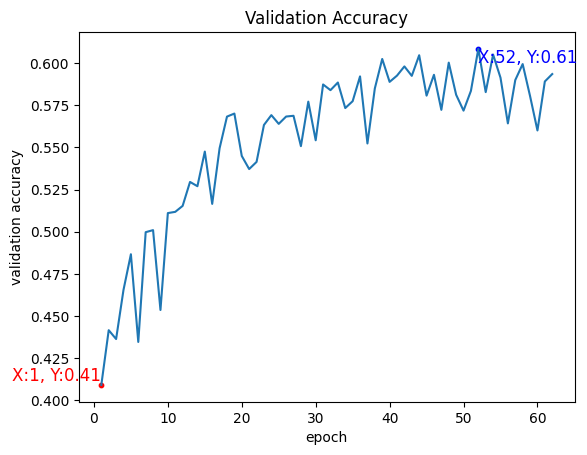

In [9]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


Test Accuracy: 57.7876845918083%
              precision    recall  f1-score   support

           0       0.48      0.56      0.52      1392
           1       0.00      0.00      0.00       401
           2       0.44      0.41      0.42      1314
           3       0.80      0.67      0.73      4027
           4       0.52      0.71      0.60      3628
           5       0.43      0.34      0.38      2178
           6       0.69      0.66      0.67      1416

    accuracy                           0.58     14356
   macro avg       0.48      0.48      0.47     14356
weighted avg       0.57      0.58      0.57     14356

Test Accuracy: 56.82641404290889%
              precision    recall  f1-score   support

           0       0.44      0.57      0.50      1392
           1       0.08      0.02      0.03       401
           2       0.48      0.41      0.44      1314
           3       0.83      0.64      0.72      4027
           4       0.53      0.65      0.59      3628
           

<Figure size 700x700 with 0 Axes>

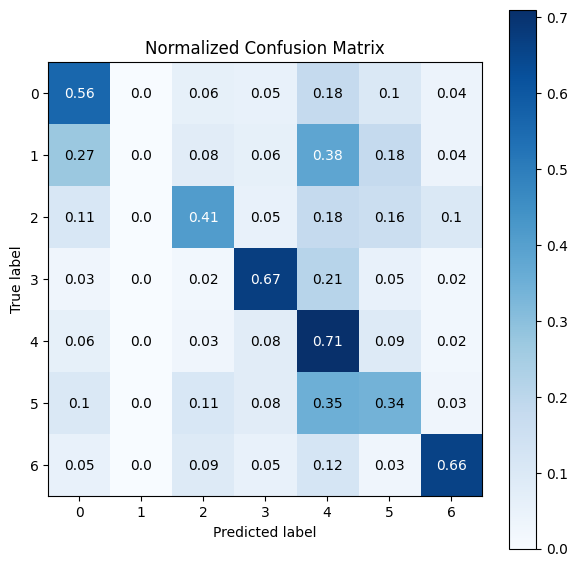

<Figure size 700x700 with 0 Axes>

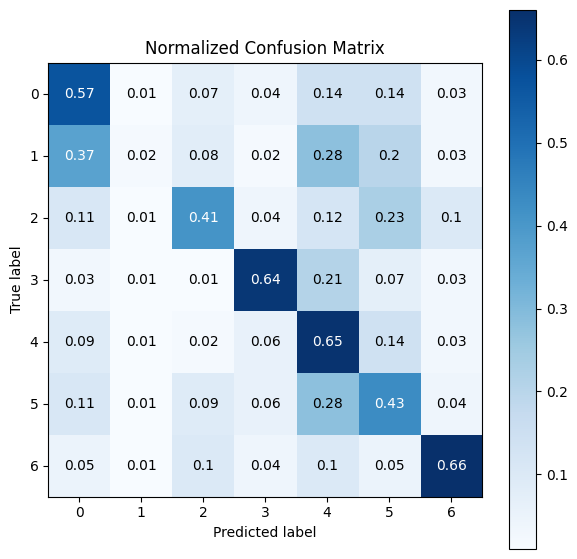

In [10]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
utility.model_validation(model, device, test_loader, m.pth_save_path, m.record_save_path)
utility.model_validation(model, device, test_loader, m.pth_manual_save_path, m.record_save_path)